# Learning Gaussian Filters

While playing around with the MNIST dataset and the [example code](https://github.com/lisa-lab/DeepLearningTutorials), I tried to visualise the weights of the connections from the weights to the hidden layer. These can be thought of as feature extractors of the input. If you've trained a denoising auto-encoder, you typically get a plot that looks something like this

<img src="http://ufldl.stanford.edu/wiki/images/a/a3/MnistVectorizationEx.png">

What I noticed about this is that there seemed to be strokes and blobs of white pixels that are clustered together. So I wondered if we could reduce the parameters to describe these blobs to the parameters that describe a 2D Gaussian function.

Turns out, it can be done pretty easily, but I'm not sure if there's any useful application for this.


$$
\newcommand{\precisionmat}{\mathbf{B}}
\newcommand{\pixel}{\mathbf{p}}
$$
We want to learn feature extractors for the input in terms of Gaussian filters with varying width height and rotations.

Let the Gaussian function be,

$$ g(\pixel;\theta,\boldsymbol{\sigma},\boldsymbol{\mu}) = \exp\left(-{\left\| \precisionmat (\pixel - \boldsymbol{\mu}) \right\|}^2\right) $$


Then we define a weight matrix $\mathbf{W}$ between layers such that,

$$ \underbrace{\mathbf{W}}_{(n,h)} = \underbrace{\mathbf{G}}_{(n,k)} \underbrace{\mathbf{M}}_{(k,h)}$$

where $\mathbf{M}$ is a standard transformation matrix freely tuned by gradient descent, and $\mathbf{G}$ is a matrix with each column representing a Gaussian filter:

$$(\mathbf{G})_{ij} = g(\left[\text{row}(i),\text{col}(i)\right];\theta_j,\boldsymbol{\sigma}_j,\boldsymbol{\mu}_j)$$


where $\text{row}(i)$ and $\text{col}(i)$ give the row and column of input $i$. As a result, the free variables for tuning the matrix $\mathbf{G}$ are then the mean/centre (2 dimensional), scale (2 dimensional), and rotation.

In this way, $\mathbf{W}$ represents a layer in which features are captured in the form of linear combinations of Gaussian shaped feature extractors from the previous layer, which is assumed to have some form of two-dimensional topology.

## The MNIST task
We compare the unconstrained version of a single hidden layer neural network against a neural network that learns gaussian feature extractors.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import cPickle as pickle
import matplotlib.cm as cm
import matplotlib
matplotlib.rcParams['savefig.dpi'] = 3 * matplotlib.rcParams['savefig.dpi']

The original unconstrained form of the learner extracts blob-like structures from the image, which suggests that constraining that extracting gaussian shaped features and learning representations in terms of them might be a good fit for this task.

We use 40 gaussian components in our initial experiments, and attained a 1.9% error rate on the test set for MNIST.

In [5]:
import cPickle as pickle
rows = 5
[gaussians,weights] = pickle.load(open('mixtures.data'))
gaussians = gaussians.T
weights = weights.T
gaussians = gaussians.reshape((rows,gaussians.shape[0]/rows,28,28))

The plot below is of the 40 gaussian components learnt to extract data from the MNIST dataset. This is the matrix $\mathbf{G}$ as mentioned earlier.

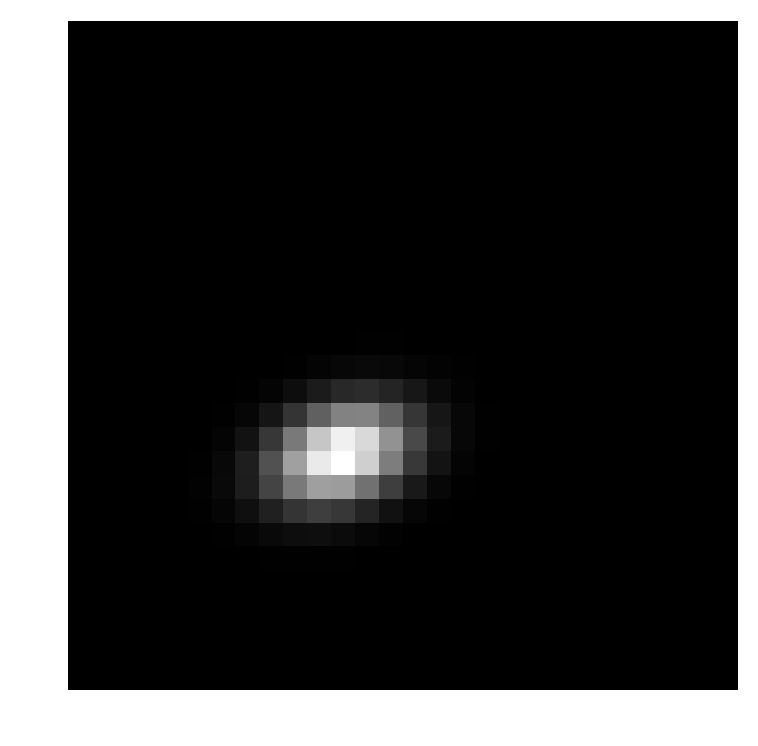

In [8]:
plt.axis('off')
plt.imshow(np.hstack(np.hstack(gaussians)),interpolation="nearest",cmap=cm.gray)
plt.imshow(gaussians[1,1],interpolation="nearest",cmap=cm.gray)

When we multiply this with the matrix $\mathbf{M}$ we get a matrix which extracts weighted sums of gaussians from $\mathbf{G}$.

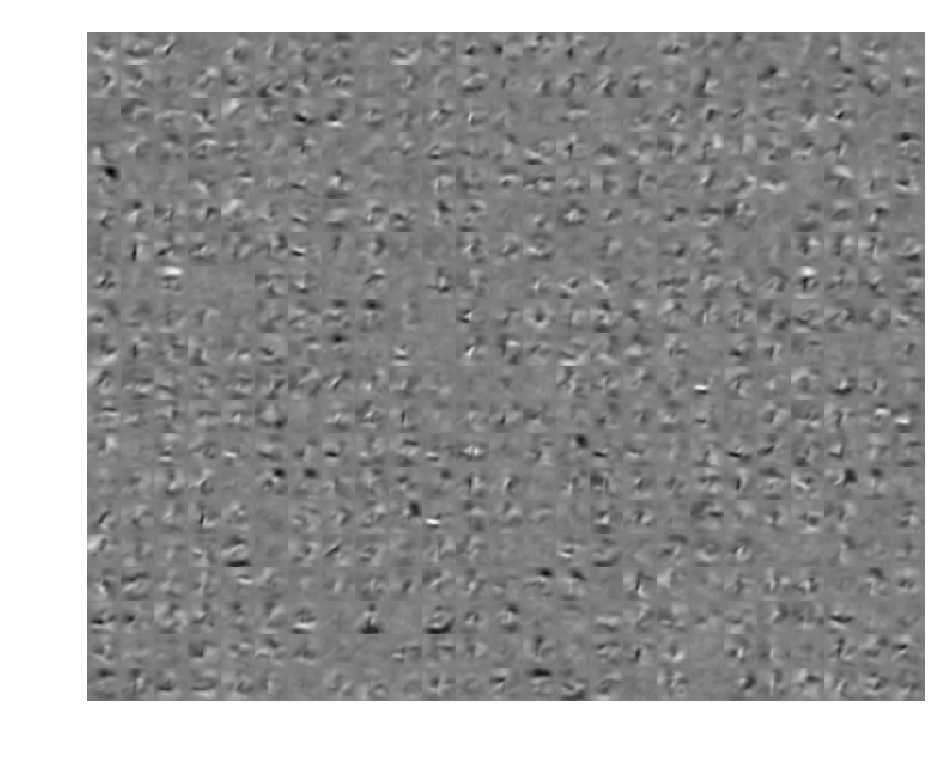

In [4]:
weights = weights.reshape((20,25,28,28))
plt.axis('off')
plt.imshow(np.hstack(np.hstack(weights)),interpolation="nearest",cmap=cm.gray)

The new system performs at 1.9% error rate, and you can see from the weights, similar sorts of feature detectors are learnt.

## Training an autoencoder

In order to train the autoencoder, we simply use the transpose of $\mathbf{W}$ for the 2nd layer, and train it using KL-divergence. We get relatively good reconstructions using 40 components.

In [10]:
from gaussian import gaussian
from theano_toolkit.parameters import Parameters
import theano.tensor as T
import theano

P = Parameters()
x = T.matrix('x')    # the data is presented as rasterized images
input_size = 28 * 28
components = 40
hidden_size = 500

rng = np.random.RandomState(1234)
P.W_gaussians_hidden  = 4 * np.asarray(rng.uniform(
                    low = -np.sqrt(6. / (components + hidden_size)),
                    high=  np.sqrt(6. / (components + hidden_size)),
                    size=(components, hidden_size)),
                dtype=theano.config.floatX)
P.b_hidden = np.zeros((hidden_size,), dtype=theano.config.floatX)
P.b_recon  = np.zeros((input_size,),  dtype=theano.config.floatX)

G = gaussian(P,28,28,components)
W = T.dot(G,P.W_gaussians_hidden)
hidden = T.nnet.sigmoid(T.dot(x,W) + P.b_hidden)
recon  = T.nnet.sigmoid(T.dot(hidden,W.T) + P.b_recon)
data = pickle.load(open('mnist.pkl'))
get_filters = theano.function(inputs=[],outputs=[G,W])
f = theano.function(inputs=[x],outputs=recon)


Couldn't import dot_parser, loading of dot files will not be possible.


In [11]:
P.load('ae_gaussian.model')

We can check out the reconstructions of several examples from the validation set, and visualise the matrices of $\mathbf{G}$ and $\mathbf{W}$ again.

677


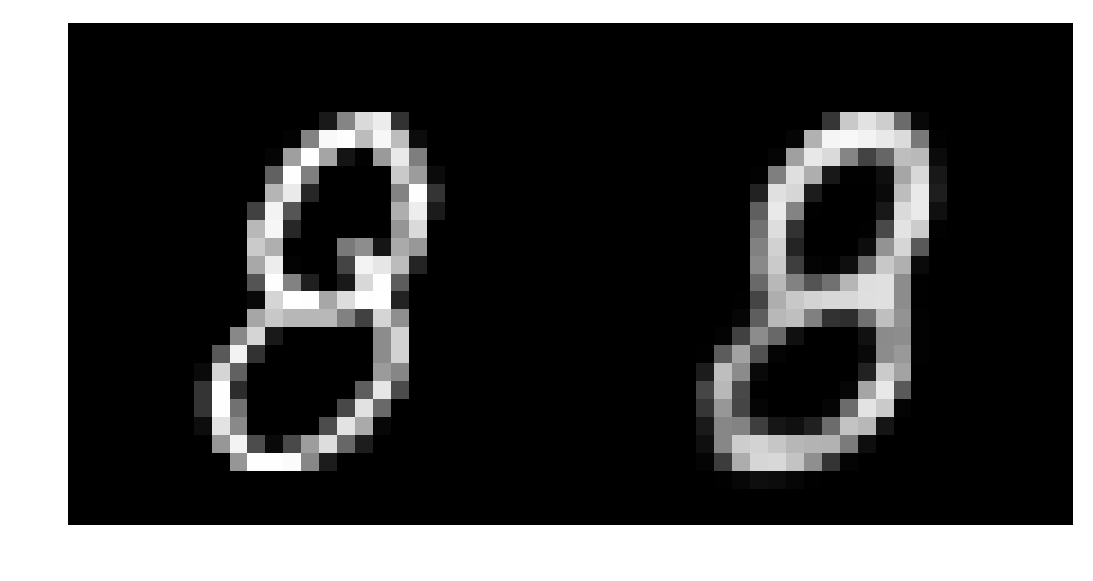

In [20]:
plt.axis('off')
images_all,labels = data[2]
import random
image = images_all[labels==8]
idx = random.randint(0,image.shape[0])
print idx
image = image[153:153+1]
recon_image = f(image).reshape(28,28)
plt.imshow(np.hstack((image.reshape(28,28),recon_image)),interpolation="nearest",cmap=cm.gray)

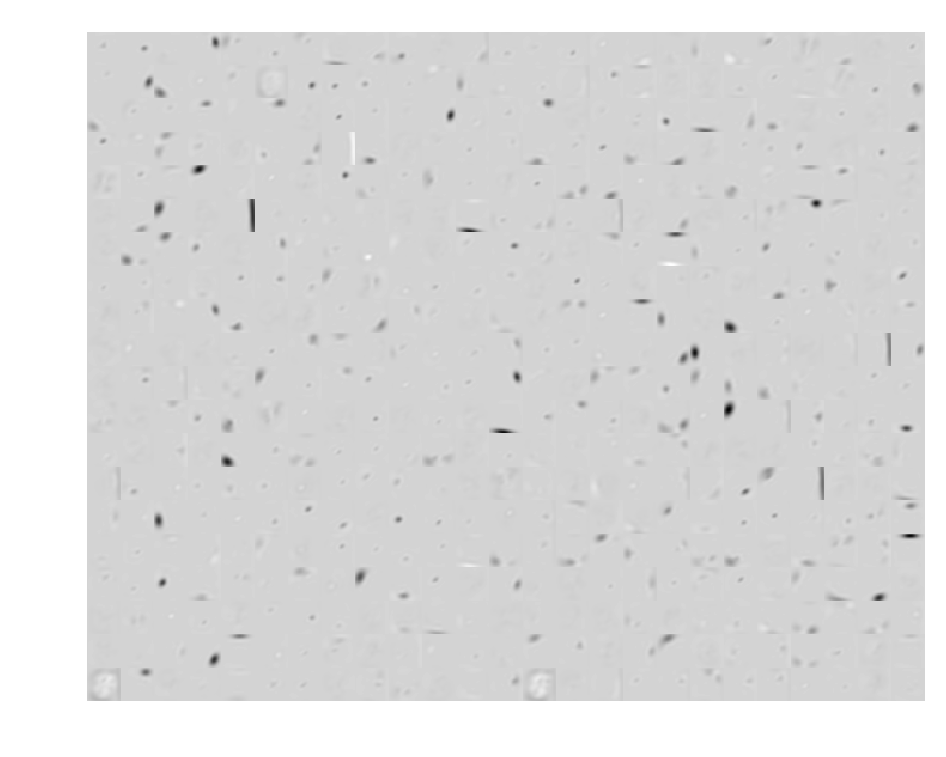

In [12]:
G,weights = get_filters()
plt.axis('off')
plt.imshow(np.hstack(np.hstack(weights.T.reshape((20,25,28,28)))),interpolation="nearest",cmap=cm.gray)

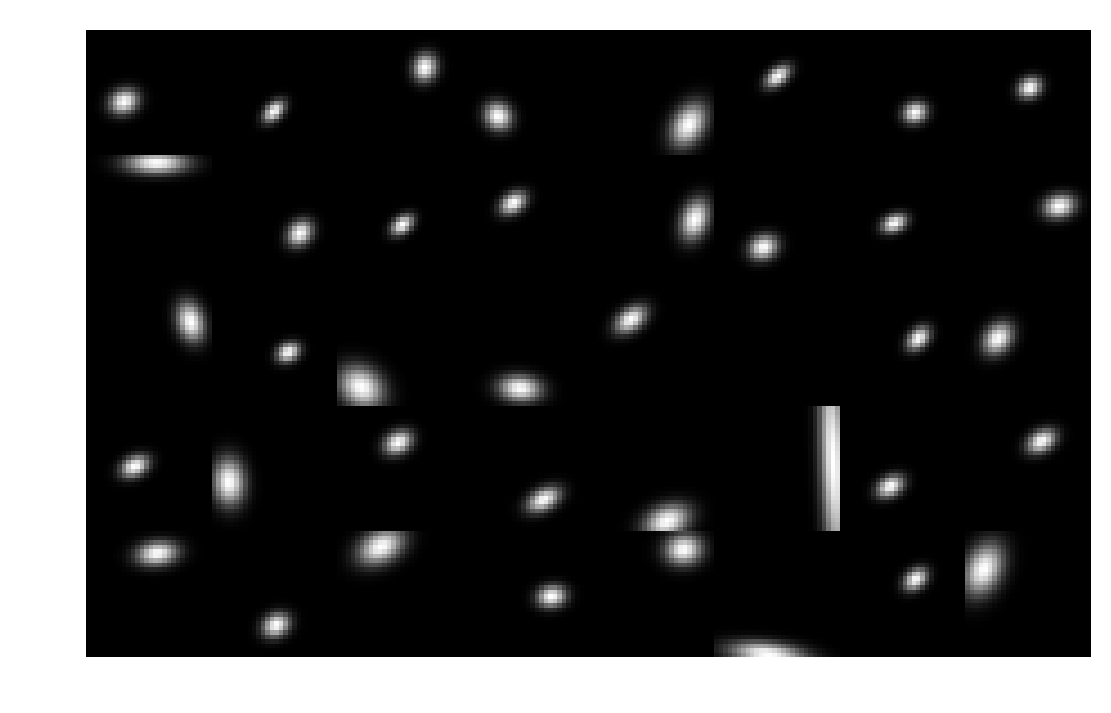

In [9]:
plt.axis('off')
plt.imshow(np.hstack(np.hstack(G.T.reshape((5,8,28,28)))),interpolation="nearest",cmap=cm.gray)

## The TIMIT task

We want to know if this technique can be used from one hidden layer to another hidden layer.

## Ideas
- Initialise the gaussian centres in a grid fashion
- $\text{row}(i)$ and $\text{col}(i)$ is an arbitrary restriction, could tune that as well.
    - Can plot out neurons in 2D space without grid restriction and see what has been learnt.
    - This means moving neurons around in 2D space affects their connection strength to next layer.
- Adaptation:
    - Use moveable neurons and translate neurons
    - Adapt the Gaussian parameters